In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from spec_id import Oldest_galaxy,Likelihood_contours
from scipy.interpolate import interp1d,interp2d
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults
import grizli.model
from astropy.io import fits
import pandas as pd
from glob import glob
from matplotlib.gridspec import GridSpec
from astropy.io import fits
from astropy.table import Table
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.1, as_cmap=True)
%matplotlib inline

In [6]:
metal=np.round(np.arange(0.002,0.031,0.001),3)
age=np.round(np.arange(.5,6.1,.1),1)
tau=[0,8.0, 8.3, 8.48, 8.6, 8.7, 8.78, 8.85, 8.9, 8.95, 9.0, 9.04, 9.08, 9.11, 9.15, 9.18, 9.2, 9.23, 9.26, 9.28,
     9.3, 9.32, 9.34, 9.36, 9.38, 9.4, 9.41, 9.43, 9.45, 9.46, 9.48]
M,A=np.meshgrid(metal,age)

In [53]:
specz = 1.248
chifile = '../chidat/s39170_full_fit_d0_chidata.npy'
rshift,Pz = np.load('../chidat/s39170_full_fit_rs_pos.npy')

In [54]:
max_age = Oldest_galaxy(1.023)

####### Read in file   
chi = np.load(chifile)

chi[ : , len(age[age <= max_age]):,:,:] = 1E5

In [35]:
chi.T.shape

(41, 31, 56, 29)

In [61]:
rshift[20]

1.0229999999999999094

In [62]:
subchi = chi.T[20].T

In [45]:
subchi.shape

(29, 56, 31)

In [63]:

####### Get scaling factor for tau reshaping
ultau = np.append(0, np.power(10, np.array(tau)[1:] - 9))

convtable = np.load('../data/light_weight_scaling_3.npy')

overhead = np.zeros([len(tau),metal.size]).astype(int)
for i in range(len(tau)):
    for ii in range(metal.size):
        amt=[]
        for iii in range(age.size):
            if age[iii] > convtable.T[i].T[ii][-1]:
                amt.append(1)
        overhead[i][ii] = sum(amt)

######## get Pd and Pz
# P_full = np.exp(- chi / 2).astype(np.float128)

# P = np.trapz(P_full, rshift, axis=3)
P = np.exp(- subchi / 2).astype(np.float128)
new_P = np.zeros(P.T.shape)

######## Reshape likelihood to get light weighted age instead of age when marginalized
for i in range(len(tau)):
    frame = np.zeros([metal.size,age.size])
    for ii in range(metal.size):
        dist = interp1d(convtable.T[i].T[ii],P.T[i].T[ii])(age[:-overhead[i][ii]])
        frame[ii] = np.append(dist,np.repeat(0, overhead[i][ii]))
    new_P[i] = frame.T

####### Create normalize probablity marginalized over tau
P = new_P.T

# test_prob = np.trapz(test_P, ultau, axis=2)
C = np.trapz(np.trapz(np.trapz(P, ultau, axis=2), age, axis=1), metal)

P /= C

prob = np.trapz(P, ultau, axis=2)

# #### Get Z, t, tau, and z posteriors
PZ = np.trapz(np.trapz(P, ultau, axis=2), age, axis=1)
Pt = np.trapz(np.trapz(P, ultau, axis=2).T, metal, axis=1)
Ptau = np.trapz(np.trapz(P.T, metal, axis=2), age, axis=1)

[0, 0.03, 0, 6]

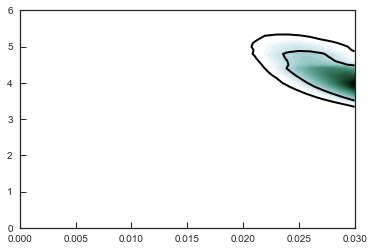

In [64]:
onesig,twosig = Likelihood_contours(age,metal,prob.T)
levels = np.array([twosig,onesig])

plt.contour(M,A,prob.T,levels,colors='k',linewidths=2)
plt.contourf(M,A,prob.T,40,cmap=cmap)
plt.axis([0,0.03,0,6])

[0, 0.03, 0, 6]

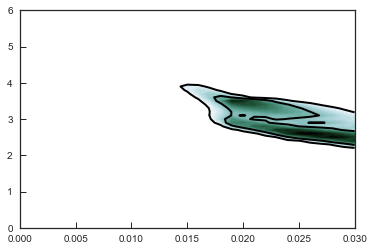

In [87]:
P2= np.load('../chidat/s39170_dtau_tZ_pos_lwa_3.npy')
onesig,twosig = Likelihood_contours(age,metal,P2)
levels = np.array([twosig,onesig])

plt.contour(M,A,P2,levels,colors='k',linewidths=2)
plt.contourf(M,A,P2,40,cmap=cmap)
plt.axis([0,0.03,0,6])

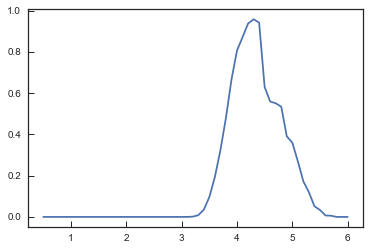

In [65]:
plt.plot(age,Pt)

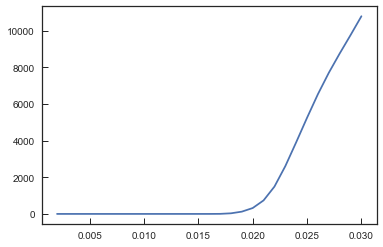

In [66]:
plt.plot(metal,PZ/0.019)

In [84]:
wv1,fl1,er1 = np.load('../spec_stacks/s39170.npy')
wv2,fl2,er2 = np.load('../spec_stacks_june14/s39170_stack.npy')

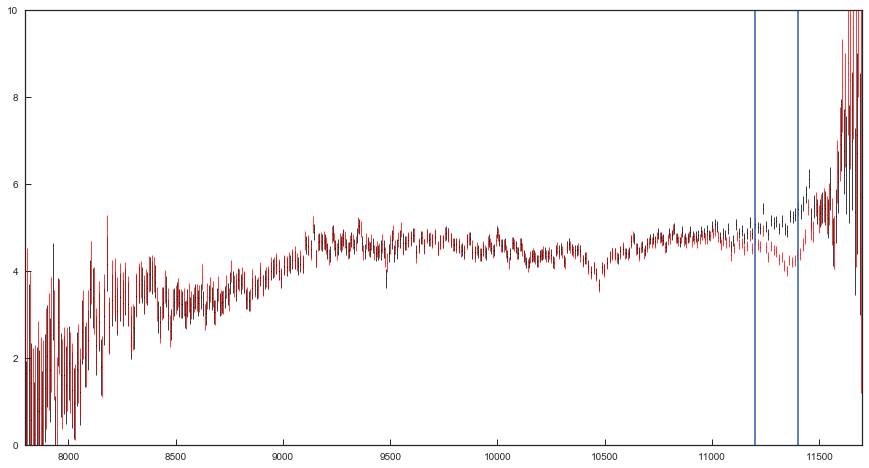

In [95]:
plt.figure(figsize=[15,8])
plt.errorbar(wv1, fl1*1E18*1.035, er1*1E18,linestyle='None', linewidth = 0.75, marker='o', markersize=1, color='k')
plt.errorbar(wv2, fl2*1E18, er2*1E18,linestyle='None', linewidth = 0.75, marker='o', markersize=1, color='r')
plt.axis([7800,11700,0,10])
plt.axvline(11200)
plt.axvline(11400)

In [88]:
ogdb = pd.read_pickle('../data/sgal_param_DB.pkl')
ngdb = pd.read_pickle('../data/upd_galDB.pkl')

In [92]:
np.array([ogdb.gids.values,ogdb.A_v.values]).T

array([['n16758', 0.5],
       ['n17070', 0.3],
       ['n19442', 0.1],
       ['n21156', 0.5],
       ['n21427', 0.1],
       ['n23435', 0.2],
       ['n32566', 0.1],
       ['n34694', 0.0],
       ['n37686', 0.2],
       ['s35774', 0.4],
       ['s38785', 0.9],
       ['s39012', 0.6],
       ['s39170', 0.7],
       ['s39241', 0.5],
       ['s39631', 0.4],
       ['s39804', 0.5],
       ['s39805', 0.6],
       ['s40223', 0.8],
       ['s40476', 0.4],
       ['s40597', 0.7],
       ['s40623', 0.8],
       ['s40862', 1.3],
       ['s41148', 0.6],
       ['s41520', 0.5],
       ['s41659', 0.8],
       ['s43615', 0.4],
       ['s44042', 0.7],
       ['s44620', 0.1],
       ['s45972', 0.1],
       ['s46066', 0.4],
       ['s46345', 0.4],
       ['s47677', 0.3],
       ['s48631', 0.7]], dtype=object)

In [93]:
np.array([ngdb.gids.values,ngdb.d.values]).T

array([['n16758', 0.1],
       ['n17070', 0.3],
       ['n21156', 0.8],
       ['n21427', 0.5],
       ['n23435', 0.5],
       ['n23758', 1.0],
       ['n32566', 0.6],
       ['n34694', 0.7],
       ['n37686', 0.9],
       ['n37955', 0.8],
       ['s35774', 0.9],
       ['s38785', 0.5],
       ['s39012', 0.5],
       ['s39170', 0.1],
       ['s39241', 0.3],
       ['s39631', 0.2],
       ['s39804', 0.5],
       ['s39805', 0.5],
       ['s40223', 0.7],
       ['s40476', 0.9],
       ['s40597', 0.6],
       ['s40623', 0.5],
       ['s40862', 0.8],
       ['s41520', 0.9],
       ['s42221', 0.2],
       ['s43615', 0.7],
       ['s44042', 0.4],
       ['s44620', 0.8],
       ['s45972', 0.1],
       ['s46066', 0.6],
       ['s47677', 0.4]], dtype=object)